In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader_60 import VitalSignsDataset,vital_pre_train
from model.retnet.autoencoder_v5_retnet import *
from model.retnet.autoencoder_v5_loss_train import *
from model.retnet.plot import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()


from torchsampler import ImbalancedDatasetSampler

2025-06-21 17:35:22.823323: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

dataset_train = VitalSignsDataset(vital_signs_train)
dataset_val = VitalSignsDataset(vital_signs_val)
dataset_test = VitalSignsDataset(vital_signs_test)


train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
train_loader_p = DataLoader(dataset_train, batch_size=32, shuffle=False, collate_fn=vital_pre_train)



labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=256,sampler=train_sampler,collate_fn=vital_pre_train )


In [ ]:
# from torch.utils.data import DataLoader, TensorDataset

# vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
# dataset_train = VitalSignsDataset(vital_signs_train)

# labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
# init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )

# train_loader = DataLoader( dataset_train,batch_size=32,shuffle=True,collate_fn=vital_pre_train )
# small_data_iter = iter(train_loader) 
# inputs, lengths,idx,cat  = next(small_data_iter)   

# original_indices = torch.arange(len(inputs))
# small_dataset = TensorDataset(inputs, lengths, original_indices, cat)

# small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 
# small_train_loader_p = DataLoader(small_dataset, batch_size=len(inputs), shuffle=False) 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_60_large_som"

model = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(16,16), lstm_dim=200,  alpha_som_q=10).to(device)

optimizer_ae = torch.optim.Adam( list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-3)
optimizer_joint = torch.optim.Adam(model.parameters(), lr=1e-4)

In [4]:
stage1_dir = os.path.join(base_dir, "stage1")
# stage1_dir = os.path.join(base_dir, "stage1_debug")

model1, hist_ae = train_vae(model, train_loader, device, optimizer=optimizer_ae, start=0,epochs=300, save_dir=stage1_dir, patience=50,kl_warmup_epochs=240)

[Epoch 50] KL weight: 0.0020, KL: 1.3374
[VAE Pretrain] Epoch 50/300 Avg ELBO: -392.8731 (Recon: -394.2105, KLw: 1.3374)
[Epoch 100] KL weight: 0.0041, KL: 2.9467
[VAE Pretrain] Epoch 100/300 Avg ELBO: -436.0780 (Recon: -439.0247, KLw: 2.9467)
[Epoch 150] KL weight: 0.0062, KL: 4.4911
[VAE Pretrain] Epoch 150/300 Avg ELBO: -477.8543 (Recon: -482.3454, KLw: 4.4911)
[Epoch 200] KL weight: 0.0083, KL: 6.0343
[VAE Pretrain] Epoch 200/300 Avg ELBO: -488.1270 (Recon: -494.1613, KLw: 6.0343)
[Epoch 250] KL weight: 0.0100, KL: 7.0878
[VAE Pretrain] Epoch 250/300 Avg ELBO: 1919509.6346 (Recon: 1919502.5198, KLw: 7.0878)
[Epoch 300] KL weight: 0.0100, KL: 7.6244
[VAE Pretrain] Epoch 300/300 Avg ELBO: -527.8683 (Recon: -535.4927, KLw: 7.6244)


In [ ]:
# stage1 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_60_vae/stage1_debug/best_vae.pth'
# model1 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

# model1.load_state_dict(torch.load(stage1, map_location=device,weights_only=True))

<All keys matched successfully>

In [5]:
initialize_som_from_data(model1, init_loader, device, som_dim=(16, 16), num_classes=4, samples_per_class=64)

[SOM Init] initialize SOM embeddings：256 vectors, each class has 64。


In [6]:
stage2_dir = os.path.join(base_dir, "stage2")
# stage2_dir = os.path.join(base_dir, "stage2_debug")

model2,hist_som = train_som( model1, train_loader, device,max_epochs=90,save_dir=stage2_dir,patience=30)

[SOM] Phase 1 Epoch 10/90 Avg Loss: 0.0126
[SOM] Phase 1 Epoch 20/90 Avg Loss: 0.0125
[SOM] Phase 1 Epoch 30/90 Avg Loss: 0.0125
[SOM] Phase 2 Epoch 40/90 Avg Loss: 0.0108
[SOM] Phase 2 Epoch 50/90 Avg Loss: 0.0108
[SOM] Phase 2 Epoch 60/90 Avg Loss: 0.0108
[SOM] Phase 3 Epoch 70/90 Avg Loss: 0.0106
[SOM] Phase 3 Epoch 80/90 Avg Loss: 0.0106
[SOM] Phase 3 Epoch 90/90 Avg Loss: 0.0107


In [ ]:
# stage2 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/stage2/best_joint.pth'
# model2 = TSAutoencoder( input_channels=154, latent_dim=64, som_dim=(10,10), lstm_dim=200, dropout=0.5, alpha_som_q=10).to(device)

# model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))

In [8]:
stage3_dir = os.path.join(base_dir, "stage3")

# stage3_dir = os.path.join(base_dir, "stage3_debug")

model3,hist_joint =train_joint(model, train_loader, val_loader,train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage3_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 100,kappa= 150, beta= 200,
                                patience =20)

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 263825


[Joint] Ep10: Calculating global target P...


[Joint] Ep10 Global P updated. Shape: torch.Size([263825, 256])


[Joint] Ep20: Calculating global target P...


[Joint] Ep20 Global P updated. Shape: torch.Size([263825, 256])


[Joint] Early stopping at epoch 21 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


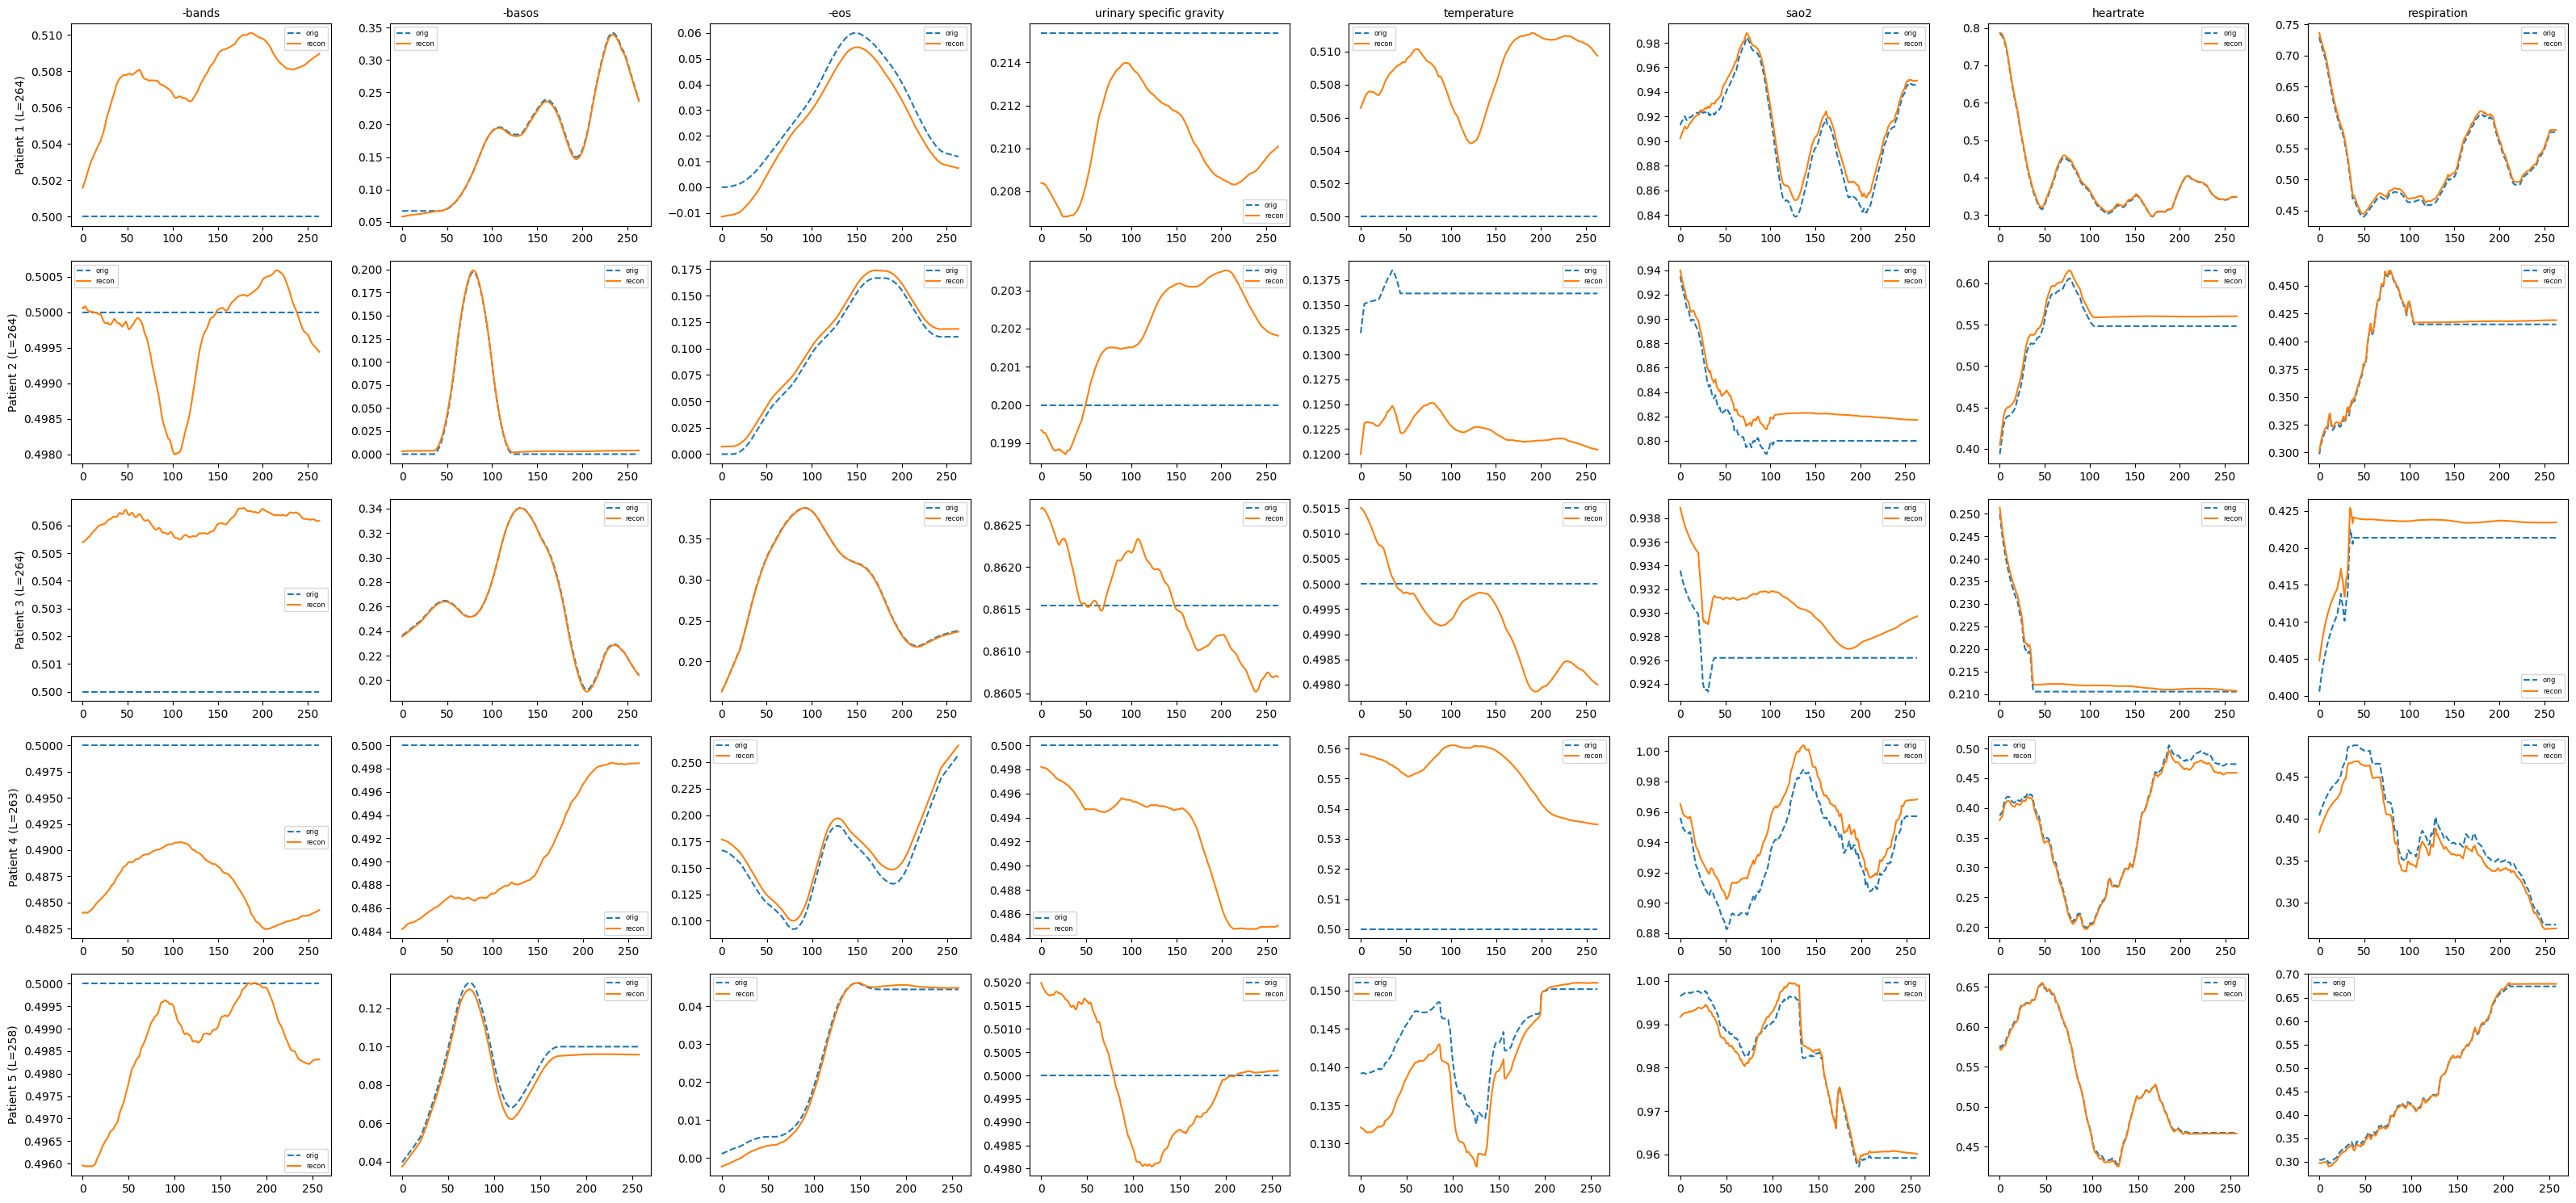

In [9]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model3, train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)


--- Latent Space Statistics ---
Analyzed 78692 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): -0.0152
  Std (overall): 0.1980
  Per-dim mean:
tensor([ 1.2978e-02,  2.1405e-02,  5.0361e-02,  1.6768e-02, -1.2579e-01,
        -2.7310e-02,  9.7585e-03, -6.8668e-03, -1.2545e-02, -5.5337e-01,
         1.0378e-02, -1.3993e-02,  1.4404e-03, -8.8193e-04,  2.0567e-02,
         1.7100e-03, -1.0982e-02, -1.9983e-02, -1.9237e-02, -5.4788e-03,
        -5.1759e-03,  2.2383e-02,  8.4641e-04, -4.1540e-03, -4.9066e-01,
        -1.0380e-02,  4.2476e-02,  1.3553e-01, -5.8270e-01, -4.8252e-02,
         1.4670e-02, -2.8320e-03, -2.9805e-02, -4.2518e-02,  3.1196e-02,
        -8.8640e-03,  9.3999e-03,  2.1420e-02,  4.1739e-02, -2.1982e-02,
        -9.9612e-03, -1.9308e-02,  1.0868e-02, -2.2008e-02, -4.6816e-03,
         2.8637e-02, -9.3930e-03, -1.6126e-02,  2.6124e-02,  4.3929e-03,
        -2.3647e-02, -1.6620e-02, -1.3539e-02,  1.4677e-02, -1.6102e-02,
         1.2360e-02, -2.0666e-02,  5.

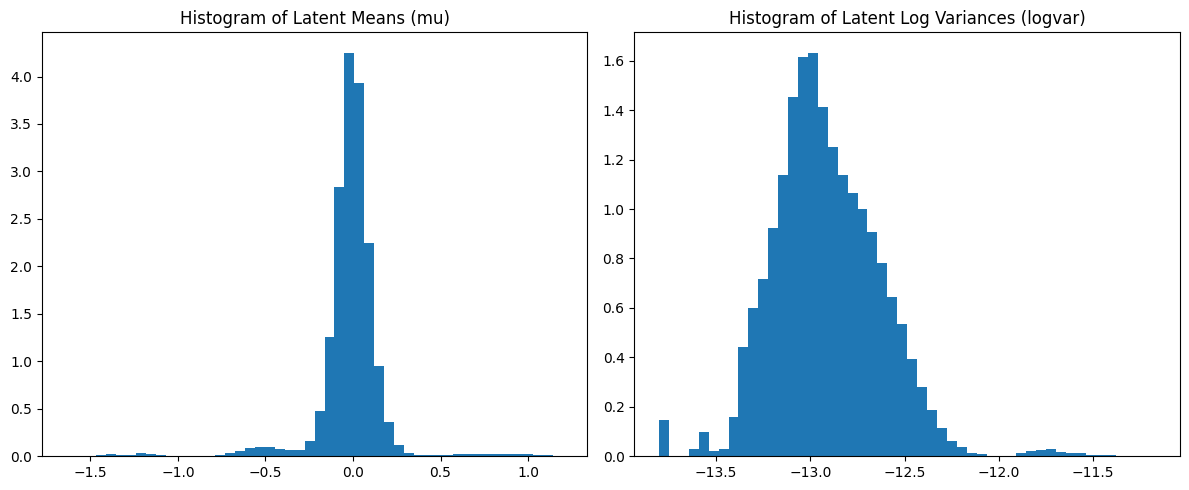

In [10]:
analyze_latent_stats(model3, train_loader, device, num_batches_to_analyze=20)

### vae 几乎退化成 ae， logvar ≈ -11.5（对应 σ² ≈ 1e-5）， 无随机性， kl值过大，与先验不服和

In [5]:
stage3 = '/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_60_large_som/stage3/best_joint.pth'
model3 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(16,16), lstm_dim=200,  alpha_som_q=5).to(device)

model3.load_state_dict(torch.load(stage3, map_location=device,weights_only=True))

<All keys matched successfully>

In [8]:
def plot_som_activation_heatmap(activation_grid):
    plt.figure(figsize=(8, 8))
    sns.heatmap(activation_grid, cmap="viridis", annot=True, fmt="d")
    plt.title("SOM Node Activation Frequency")
    plt.xlabel("SOM Width")
    plt.ylabel("SOM Height")
    plt.tight_layout()
    plt.show()
    

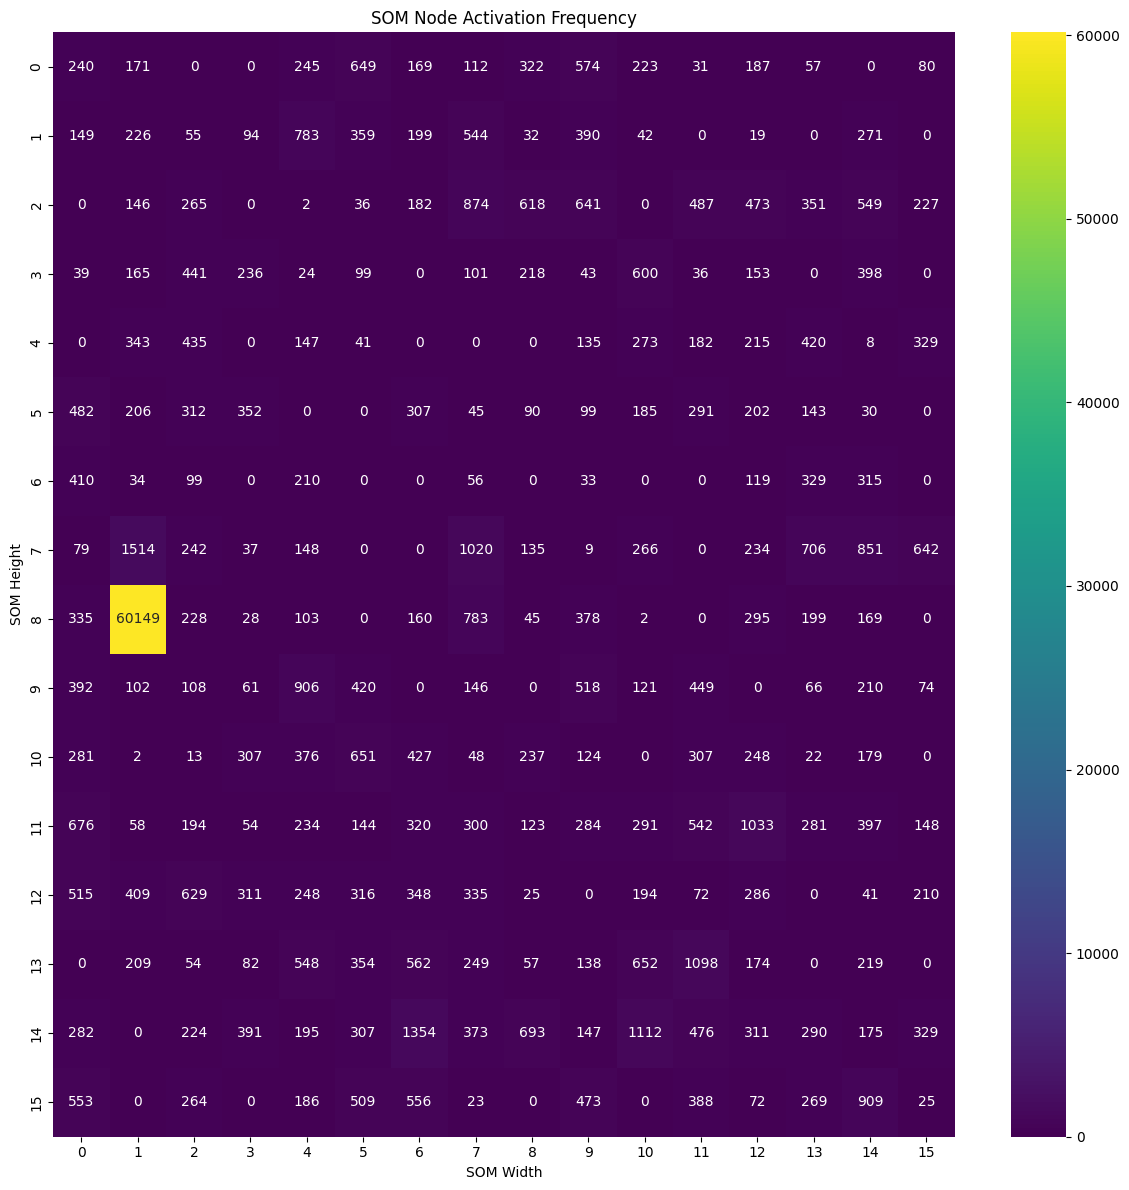

In [7]:
activation_map = compute_som_activation_heatmap(model3, test_loader, device)
plot_som_activation_heatmap(activation_map)

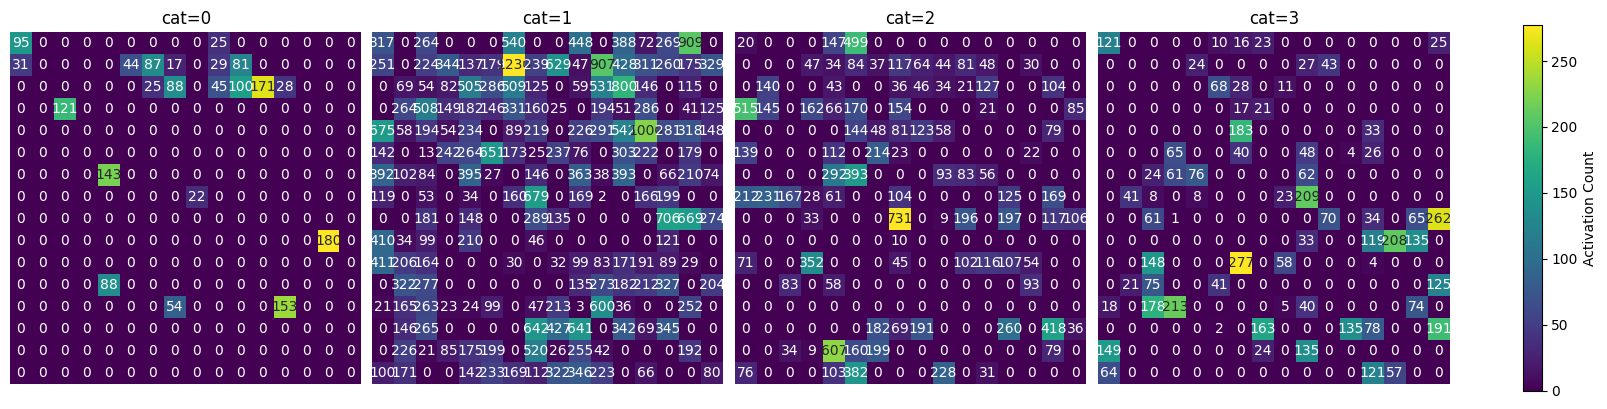

In [14]:

som_dim = (16,16)
hm_by_cat = compute_som_activation_by_category(model3, test_loader, device, som_dim)
plot_som_usage_by_category(hm_by_cat, som_dim)

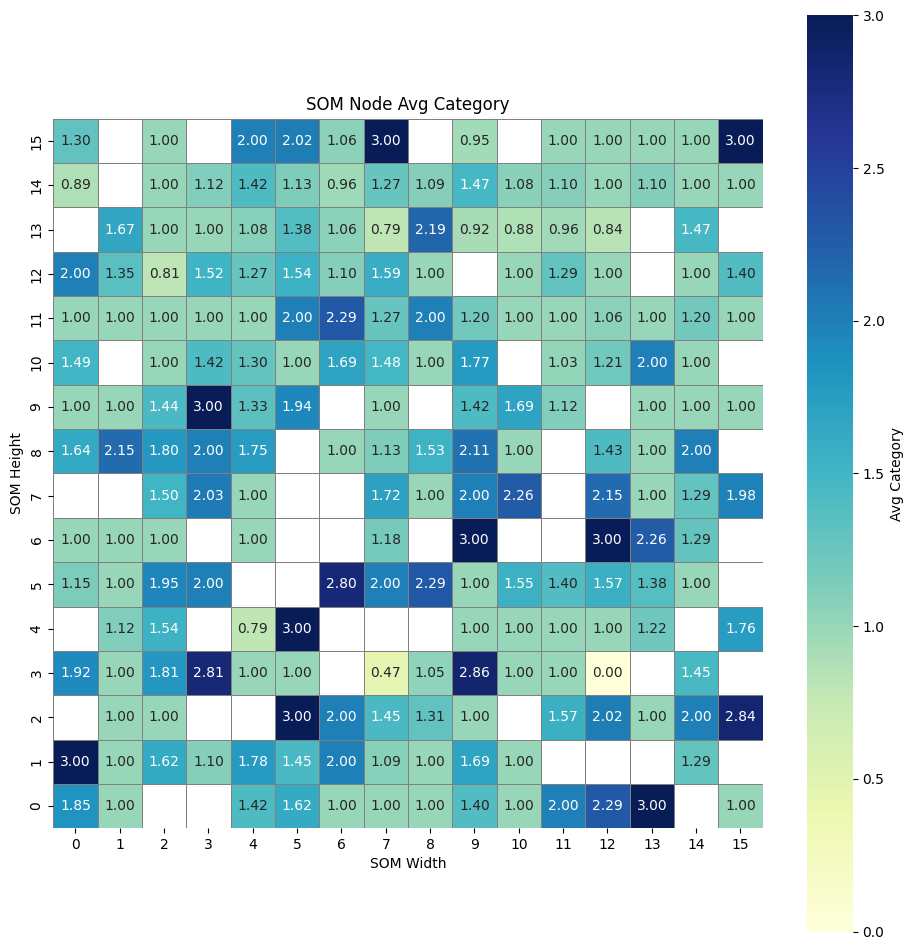

In [15]:
som_dim = (16,16)
avg_cat_map = compute_som_avg_category(model3, test_loader, device, som_dim)
plot_som_avg_category(avg_cat_map, som_dim)